In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('../dataset/train_v2.csv')

In [3]:
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# 把二维list变为一维list
flatten = lambda l: [item for sublist in l for item in sublist]
# 获取所有标签种类
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
labels

['cloudy',
 'cultivation',
 'agriculture',
 'partly_cloudy',
 'primary',
 'haze',
 'selective_logging',
 'water',
 'blooming',
 'slash_burn',
 'habitation',
 'blow_down',
 'road',
 'artisinal_mine',
 'clear',
 'bare_ground',
 'conventional_mine']

In [5]:
# label到索引的映射
label_map = {l: i for i, l in enumerate(labels)}
# 索引到label的映射
inv_label_map = {i: l for l, i in label_map.items()}
inv_label_map

{0: 'cloudy',
 1: 'cultivation',
 2: 'agriculture',
 3: 'partly_cloudy',
 4: 'primary',
 5: 'haze',
 6: 'selective_logging',
 7: 'water',
 8: 'blooming',
 9: 'slash_burn',
 10: 'habitation',
 11: 'blow_down',
 12: 'road',
 13: 'artisinal_mine',
 14: 'clear',
 15: 'bare_ground',
 16: 'conventional_mine'}

(<matplotlib.axes._subplots.AxesSubplot at 0x1dfe0d89dd8>,
 <matplotlib.text.Text at 0x1dfe08e5cf8>)

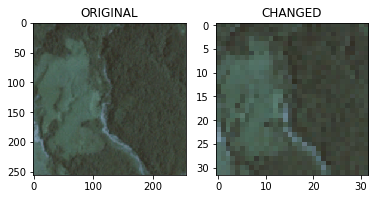

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
img = cv2.imread('../dataset/train-jpg/train_1.jpg')
img2 = cv2.resize(img, (32, 32))
plt.subplot(1,2,1), plt.imshow(img),plt.title('ORIGINAL')
plt.subplot(1,2,2), plt.imshow(img2),plt.title('CHANGED')

In [7]:
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../dataset/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (32, 32)))
    y_train.append(targets)

100%|█████████████████████████████████████████| 40479/40479 [20:25<00:00, 33.03it/s]


In [8]:
# test-jpg:40669 test-jpg-additional:20522
x_test = []
test_index = [x for x in range(40669)]
file_index = [x for x in range(20522)]
for index in tqdm(test_index, miniters=1000):
    img = cv2.imread('../dataset/test-jpg/test_{}.jpg'.format(index))
    x_test.append(cv2.resize(img, (32,32)))
for index in tqdm(file_index, miniters=1000):
    img = cv2.imread('../dataset/test-jpg-additional/file_{}.jpg'.format(index))
    x_test.append(cv2.resize(img, (32,32)))

100%|█████████████████████████████████████████| 20522/20522 [05:12<00:00, 65.60it/s]


AttributeError: 'list' object has no attribute 'size'

In [9]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

(40479, 32, 32, 3)
(40479, 17)


In [10]:
split = 35000
x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
              
model.fit(x_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(x_valid, y_valid))

Train on 35000 samples, validate on 5479 samples
Epoch 1/4


26624/35000 [=====================>........] - ETA: 682s - loss: 0.6965 - acc: 0.516 - ETA: 403s - loss: 0.5971 - acc: 0.661 - ETA: 318s - loss: 0.5404 - acc: 0.724 - ETA: 270s - loss: 0.5146 - acc: 0.758 - ETA: 242s - loss: 0.4895 - acc: 0.780 - ETA: 221s - loss: 0.4779 - acc: 0.794 - ETA: 206s - loss: 0.4646 - acc: 0.805 - ETA: 193s - loss: 0.4549 - acc: 0.813 - ETA: 184s - loss: 0.4488 - acc: 0.819 - ETA: 176s - loss: 0.4425 - acc: 0.823 - ETA: 170s - loss: 0.4365 - acc: 0.827 - ETA: 165s - loss: 0.4310 - acc: 0.831 - ETA: 163s - loss: 0.4255 - acc: 0.835 - ETA: 159s - loss: 0.4210 - acc: 0.838 - ETA: 158s - loss: 0.4155 - acc: 0.841 - ETA: 154s - loss: 0.4111 - acc: 0.844 - ETA: 151s - loss: 0.4068 - acc: 0.846 - ETA: 149s - loss: 0.4029 - acc: 0.848 - ETA: 153s - loss: 0.3990 - acc: 0.850 - ETA: 152s - loss: 0.3941 - acc: 0.852 - ETA: 150s - loss: 0.3897 - acc: 0.854 - ETA: 149s - loss: 0.3857 - acc: 0.856 - ETA: 147s - loss: 0.3820 - acc: 0.857 - ETA: 145s - loss: 0.3777 - acc: 0

35000/35000 [==============================] - ETA: 34s - loss: 0.2598 - acc: 0.90 - ETA: 33s - loss: 0.2596 - acc: 0.90 - ETA: 33s - loss: 0.2595 - acc: 0.90 - ETA: 32s - loss: 0.2592 - acc: 0.90 - ETA: 32s - loss: 0.2590 - acc: 0.90 - ETA: 31s - loss: 0.2587 - acc: 0.90 - ETA: 30s - loss: 0.2586 - acc: 0.90 - ETA: 30s - loss: 0.2584 - acc: 0.90 - ETA: 29s - loss: 0.2582 - acc: 0.90 - ETA: 29s - loss: 0.2581 - acc: 0.90 - ETA: 28s - loss: 0.2579 - acc: 0.90 - ETA: 28s - loss: 0.2579 - acc: 0.90 - ETA: 27s - loss: 0.2578 - acc: 0.90 - ETA: 27s - loss: 0.2577 - acc: 0.90 - ETA: 26s - loss: 0.2575 - acc: 0.90 - ETA: 26s - loss: 0.2574 - acc: 0.90 - ETA: 25s - loss: 0.2572 - acc: 0.90 - ETA: 24s - loss: 0.2570 - acc: 0.90 - ETA: 24s - loss: 0.2569 - acc: 0.90 - ETA: 23s - loss: 0.2568 - acc: 0.90 - ETA: 23s - loss: 0.2567 - acc: 0.90 - ETA: 22s - loss: 0.2565 - acc: 0.90 - ETA: 22s - loss: 0.2564 - acc: 0.90 - ETA: 21s - loss: 0.2562 - acc: 0.90 - ETA: 21s - loss: 0.2563 - acc: 0.90 - ETA

26880/35000 [======================>.......] - ETA: 135s - loss: 0.2136 - acc: 0.923 - ETA: 127s - loss: 0.2137 - acc: 0.918 - ETA: 128s - loss: 0.2136 - acc: 0.916 - ETA: 127s - loss: 0.2159 - acc: 0.915 - ETA: 125s - loss: 0.2142 - acc: 0.916 - ETA: 124s - loss: 0.2207 - acc: 0.914 - ETA: 123s - loss: 0.2207 - acc: 0.915 - ETA: 122s - loss: 0.2215 - acc: 0.913 - ETA: 122s - loss: 0.2206 - acc: 0.914 - ETA: 121s - loss: 0.2214 - acc: 0.913 - ETA: 122s - loss: 0.2220 - acc: 0.913 - ETA: 121s - loss: 0.2230 - acc: 0.912 - ETA: 120s - loss: 0.2220 - acc: 0.912 - ETA: 119s - loss: 0.2208 - acc: 0.913 - ETA: 118s - loss: 0.2207 - acc: 0.913 - ETA: 117s - loss: 0.2197 - acc: 0.914 - ETA: 117s - loss: 0.2189 - acc: 0.914 - ETA: 116s - loss: 0.2179 - acc: 0.914 - ETA: 116s - loss: 0.2191 - acc: 0.914 - ETA: 115s - loss: 0.2188 - acc: 0.914 - ETA: 115s - loss: 0.2188 - acc: 0.914 - ETA: 115s - loss: 0.2177 - acc: 0.915 - ETA: 114s - loss: 0.2180 - acc: 0.915 - ETA: 114s - loss: 0.2176 - acc: 0

35000/35000 [==============================] - ETA: 33s - loss: 0.2073 - acc: 0.91 - ETA: 32s - loss: 0.2073 - acc: 0.91 - ETA: 32s - loss: 0.2073 - acc: 0.91 - ETA: 31s - loss: 0.2072 - acc: 0.91 - ETA: 31s - loss: 0.2071 - acc: 0.91 - ETA: 30s - loss: 0.2070 - acc: 0.91 - ETA: 29s - loss: 0.2069 - acc: 0.91 - ETA: 29s - loss: 0.2070 - acc: 0.91 - ETA: 28s - loss: 0.2069 - acc: 0.91 - ETA: 28s - loss: 0.2069 - acc: 0.91 - ETA: 27s - loss: 0.2069 - acc: 0.91 - ETA: 27s - loss: 0.2068 - acc: 0.91 - ETA: 26s - loss: 0.2067 - acc: 0.91 - ETA: 26s - loss: 0.2067 - acc: 0.91 - ETA: 25s - loss: 0.2068 - acc: 0.91 - ETA: 25s - loss: 0.2068 - acc: 0.91 - ETA: 24s - loss: 0.2069 - acc: 0.91 - ETA: 24s - loss: 0.2069 - acc: 0.91 - ETA: 23s - loss: 0.2068 - acc: 0.91 - ETA: 22s - loss: 0.2068 - acc: 0.91 - ETA: 22s - loss: 0.2069 - acc: 0.91 - ETA: 21s - loss: 0.2068 - acc: 0.91 - ETA: 21s - loss: 0.2068 - acc: 0.91 - ETA: 20s - loss: 0.2069 - acc: 0.91 - ETA: 20s - loss: 0.2069 - acc: 0.91 - ETA

26880/35000 [======================>.......] - ETA: 198s - loss: 0.1881 - acc: 0.921 - ETA: 181s - loss: 0.1960 - acc: 0.922 - ETA: 176s - loss: 0.2005 - acc: 0.922 - ETA: 178s - loss: 0.1943 - acc: 0.925 - ETA: 173s - loss: 0.1927 - acc: 0.925 - ETA: 198s - loss: 0.1943 - acc: 0.925 - ETA: 197s - loss: 0.1942 - acc: 0.923 - ETA: 203s - loss: 0.1958 - acc: 0.923 - ETA: 199s - loss: 0.1980 - acc: 0.922 - ETA: 194s - loss: 0.1963 - acc: 0.923 - ETA: 188s - loss: 0.1966 - acc: 0.923 - ETA: 183s - loss: 0.1966 - acc: 0.923 - ETA: 178s - loss: 0.1971 - acc: 0.923 - ETA: 174s - loss: 0.1974 - acc: 0.922 - ETA: 170s - loss: 0.1963 - acc: 0.923 - ETA: 167s - loss: 0.1946 - acc: 0.924 - ETA: 165s - loss: 0.1951 - acc: 0.923 - ETA: 162s - loss: 0.1959 - acc: 0.923 - ETA: 159s - loss: 0.1965 - acc: 0.923 - ETA: 156s - loss: 0.1966 - acc: 0.923 - ETA: 154s - loss: 0.1967 - acc: 0.922 - ETA: 152s - loss: 0.1965 - acc: 0.922 - ETA: 150s - loss: 0.1967 - acc: 0.922 - ETA: 149s - loss: 0.1961 - acc: 0

35000/35000 [==============================] - ETA: 34s - loss: 0.1916 - acc: 0.92 - ETA: 33s - loss: 0.1914 - acc: 0.92 - ETA: 33s - loss: 0.1913 - acc: 0.92 - ETA: 32s - loss: 0.1913 - acc: 0.92 - ETA: 31s - loss: 0.1913 - acc: 0.92 - ETA: 31s - loss: 0.1913 - acc: 0.92 - ETA: 30s - loss: 0.1911 - acc: 0.92 - ETA: 30s - loss: 0.1912 - acc: 0.92 - ETA: 29s - loss: 0.1914 - acc: 0.92 - ETA: 29s - loss: 0.1913 - acc: 0.92 - ETA: 28s - loss: 0.1913 - acc: 0.92 - ETA: 28s - loss: 0.1912 - acc: 0.92 - ETA: 27s - loss: 0.1911 - acc: 0.92 - ETA: 26s - loss: 0.1910 - acc: 0.92 - ETA: 26s - loss: 0.1910 - acc: 0.92 - ETA: 25s - loss: 0.1909 - acc: 0.92 - ETA: 25s - loss: 0.1909 - acc: 0.92 - ETA: 24s - loss: 0.1908 - acc: 0.92 - ETA: 24s - loss: 0.1908 - acc: 0.92 - ETA: 23s - loss: 0.1909 - acc: 0.92 - ETA: 23s - loss: 0.1909 - acc: 0.92 - ETA: 22s - loss: 0.1908 - acc: 0.92 - ETA: 21s - loss: 0.1908 - acc: 0.92 - ETA: 21s - loss: 0.1908 - acc: 0.92 - ETA: 20s - loss: 0.1909 - acc: 0.92 - ETA

27008/35000 [======================>.......] - ETA: 149s - loss: 0.1789 - acc: 0.928 - ETA: 137s - loss: 0.1803 - acc: 0.928 - ETA: 135s - loss: 0.1813 - acc: 0.928 - ETA: 134s - loss: 0.1844 - acc: 0.927 - ETA: 134s - loss: 0.1818 - acc: 0.929 - ETA: 132s - loss: 0.1820 - acc: 0.929 - ETA: 129s - loss: 0.1777 - acc: 0.931 - ETA: 127s - loss: 0.1770 - acc: 0.931 - ETA: 127s - loss: 0.1802 - acc: 0.930 - ETA: 126s - loss: 0.1819 - acc: 0.929 - ETA: 127s - loss: 0.1812 - acc: 0.929 - ETA: 127s - loss: 0.1803 - acc: 0.929 - ETA: 126s - loss: 0.1798 - acc: 0.929 - ETA: 124s - loss: 0.1799 - acc: 0.929 - ETA: 124s - loss: 0.1815 - acc: 0.929 - ETA: 124s - loss: 0.1812 - acc: 0.929 - ETA: 123s - loss: 0.1807 - acc: 0.929 - ETA: 123s - loss: 0.1801 - acc: 0.929 - ETA: 122s - loss: 0.1803 - acc: 0.929 - ETA: 122s - loss: 0.1805 - acc: 0.929 - ETA: 121s - loss: 0.1807 - acc: 0.929 - ETA: 121s - loss: 0.1803 - acc: 0.930 - ETA: 121s - loss: 0.1804 - acc: 0.930 - ETA: 121s - loss: 0.1806 - acc: 0

35000/35000 [==============================] - ETA: 32s - loss: 0.1821 - acc: 0.92 - ETA: 31s - loss: 0.1821 - acc: 0.92 - ETA: 31s - loss: 0.1821 - acc: 0.92 - ETA: 30s - loss: 0.1820 - acc: 0.92 - ETA: 30s - loss: 0.1819 - acc: 0.92 - ETA: 29s - loss: 0.1819 - acc: 0.92 - ETA: 29s - loss: 0.1818 - acc: 0.92 - ETA: 28s - loss: 0.1817 - acc: 0.92 - ETA: 28s - loss: 0.1817 - acc: 0.92 - ETA: 27s - loss: 0.1818 - acc: 0.92 - ETA: 27s - loss: 0.1818 - acc: 0.92 - ETA: 26s - loss: 0.1818 - acc: 0.92 - ETA: 25s - loss: 0.1818 - acc: 0.92 - ETA: 25s - loss: 0.1817 - acc: 0.92 - ETA: 24s - loss: 0.1817 - acc: 0.92 - ETA: 24s - loss: 0.1816 - acc: 0.92 - ETA: 23s - loss: 0.1817 - acc: 0.92 - ETA: 23s - loss: 0.1817 - acc: 0.92 - ETA: 22s - loss: 0.1817 - acc: 0.92 - ETA: 22s - loss: 0.1817 - acc: 0.92 - ETA: 21s - loss: 0.1817 - acc: 0.92 - ETA: 21s - loss: 0.1817 - acc: 0.92 - ETA: 20s - loss: 0.1817 - acc: 0.92 - ETA: 20s - loss: 0.1816 - acc: 0.92 - ETA: 19s - loss: 0.1817 - acc: 0.92 - ETA

In [ ]:
from sklearn.metrics import fbeta_score

p_valid = model.predict(x_valid, batch_size=128)
print(y_valid)
print(p_valid)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

In [ ]:
X_test = np.array(x_test, np.float16) / 255.
y_pred = model.predict(X_test, batch_size=128)
results = []
labels_num=17
for item in y_pred:
    result = []
    for i in range(labels_num):
        if item[i] > 0.2:
            result.append(inv_label_map[i])
    results.append(' '.join(result))
results[61180:]

In [ ]:
test_pred_id = ['test_'+ str(x) for x in range(40669)]
file_pred_id = ['file_' +str(x) for x in range(20522)]
test_pred_id.extend(file_pred_id)

In [ ]:
out_df = pd.DataFrame({"image_name":test_pred_id, 'tags':results})
out_df.to_csv('../output/first_try.csv', index=False)